# Mapping mouse intestinal cell types to 10X Visium with Cell2location

From original C2L tutorial: https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html

This tutorial shows how to use cell2location method for spatially resolving fine-grained cell types by integrating 10X Visium data with scRNA-seq reference of cell types. Cell2location is a principled Bayesian model that estimates which combination of cell types in which cell abundance could have given the mRNA counts in the spatial data, while modelling technical effects (platform/technology effect, contaminating RNA, unexplained variance).

<div class="alert alert-info">
<b>Note!</b>

Cell2location is an independent package, but is powered by scvi-tools. If you have questions about cell2location, Visium data or scvi-tools please visit https://discourse.scverse.org/c/ecosytem/cell2location/42, https://discourse.scverse.org/c/general/visium/32 or https://discourse.scverse.org/c/help/scvi-tools/7 correspondingly.

</div>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BayraktarLab/cell2location/blob/master/docs/notebooks/cell2location_tutorial.ipynb)

In this tutorial, we analyse a publicly available Visium dataset of the human lymph node from 10X Genomics, and spatially map a comprehensive atlas of 34 reference cell types derived by integration of scRNA-seq datasets from human secondary lymphoid organs.

- Cell2location provides high sensitivity and resolution by borrowing statistical strength across locations. This is achieved by modelling similarity of location patterns between cell types using a hierarchical factorisation of cell abundance into tissue zones as a prior (see paper methods).

- Using our statistical method based on Negative Binomial regression to robustly combine scRNA-seq reference data across technologies and batches results in improved spatial mapping accuracy. Given cell type annotation for each cell, the corresponding reference cell type signatures $g_{f,g}$, which represent the average mRNA count of each gene $g$ in each cell type $f$, can be estimated from sc/snRNA-seq data using either 1) NB regression or 2) a hard-coded computation of per-cluster average mRNA counts for individual genes.  We generally recommend using NB regression. This notebook shows use a dataset composed on multiple batches and technologies.When the batch effects are small, a faster hard-coded method of computing per cluster averages provides similarly high accuracy. We also recommend the hard-coded method for non-UMI technologies such as Smart-Seq 2.

- Cell2location needs untransformed unnormalised spatial mRNA counts as input. 

- You also need to provide cell2location with the expected average cell abundance per location which is used as a prior to guide estimation of absolute cell abundance. This value depends on the tissue and can be estimated by counting nuclei for a few locations in the paired histology image but can be approximate (see [paper methods for more guidance](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf)).


## Workflow diagram

![Figure 1.](https://raw.githubusercontent.com/BayraktarLab/cell2location/master/docs/images/FigS1_cell2location_workflow.png)  


## Contents
* [Loading packages](#Loading-packages)
* [Loading Visium and single cell data data](#Loading-Visium-and-scRNA-seq-reference-data)
1. [Estimating cell type signatures (NB regression)](#Estimation-of-reference-cell-type-signatures-(NB-regression))
2. [Cell2location: spatial mapping](#Cell2location:-spatial-mapping)
3. [Visualising cell abundance in spatial coordinates](#Visualising-cell-abundance-in-spatial-coordinates)
4. [Downstream analysis](#Downstream-analysis)
* [Leiden clustering of cell abundance](#Identifying-discrete-tissue-regions-by-Leiden-clustering)
* [Identifying cellular compartments / tissue zones using matrix factorisation (NMF)](#Identifying-cellular-compartments-/-tissue-zones-using-matrix-factorisation-(NMF))
* [Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM)](#Estimate-cell-type-specific-expression-of-every-gene-in-the-spatial-data-(needed-for-NCEM))
5. [Advanced use](#Advanced-use)
* [Working with the posterior distribution and computing arbitrary quantiles](#Working-with-the-posterior-distribution-and-computing-arbitrary-quantiles)

## Loading packages <a class="anchor" id="Loading-packages"></a>

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import pandas as pd

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

Global seed set to 0
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


First, let's define where we save the results of our analysis:

In [ ]:
# Set paths to data and results used through the document:
sp_data_folder = '/lustre/scratch126/cellgen/team205/rb29/mice-gut.TCRtg/mouseST_C2L/data/'
results_folder = '/lustre/scratch126/cellgen/team205/rb29/mice-gut.TCRtg/mouseST_C2L/models/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map_tissueDetQCed'

## Loading Visium and scRNA-seq reference data <a class="anchor" id="Loading-Visium-and-scRNA-seq-reference-data"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we use lymph node data generated by 10X and presented in [Kleshchevnikov et al (section 4, Fig 4)](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1). This dataset can be conveniently downloaded and imported using scanpy. See [this tutorial](https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_short_demo.html) for a more extensive and practical example of data loading (multiple visium samples).

In [3]:
adata_vis=sc.read(sp_data_folder+'mouseST_all_tissueDect_QCed.h5ad')
# adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [4]:
adata_vis.obs['sample'].unique()

['1A_Hh.only', '1B_Hh.anti_IL10r', '2A_Hh.only', '2B_Hh.anti_IL10r', '3A_Hh.only', '3B_Hh.anti_IL10r', '4A_Hh.only', '4B_Hh.anti_IL10r']
Categories (8, object): ['1A_Hh.only', '1B_Hh.anti_IL10r', '2A_Hh.only', '2B_Hh.anti_IL10r', '3A_Hh.only', '3B_Hh.anti_IL10r', '4A_Hh.only', '4B_Hh.anti_IL10r']

In [5]:
adata_vis.var

,feature_types,genome,SYMBOL,mt,n_cells_by_counts-1A_Hh.only,mean_counts-1A_Hh.only,log1p_mean_counts-1A_Hh.only,pct_dropout_by_counts-1A_Hh.only,total_counts-1A_Hh.only,log1p_total_counts-1A_Hh.only,...,log1p_mean_counts-4A_Hh.only,pct_dropout_by_counts-4A_Hh.only,total_counts-4A_Hh.only,log1p_total_counts-4A_Hh.only,n_cells_by_counts-4B_Hh.anti_IL10r,mean_counts-4B_Hh.anti_IL10r,log1p_mean_counts-4B_Hh.anti_IL10r,pct_dropout_by_counts-4B_Hh.anti_IL10r,total_counts-4B_Hh.anti_IL10r,log1p_total_counts-4B_Hh.anti_IL10r
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,Gene Expression,mm10,Xkr4,False,3,0.001046,0.001046,99.895361,3.0,1.386294,...,0.000255,99.974477,1.0,0.693147,4,0.001183,0.001183,99.881657,4.0,1.609438
ENSMUSG00000089699,Gene Expression,mm10,Gm1992,False,9,0.003139,0.003134,99.686083,9.0,2.302585,...,0.000765,99.923430,3.0,1.386294,2,0.000592,0.000592,99.940828,2.0,1.098612
ENSMUSG00000102331,Gene Expression,mm10,Gm19938,False,4,0.001395,0.001394,99.860481,4.0,1.609438,...,0.000765,99.923430,3.0,1.386294,2,0.000592,0.000592,99.940828,2.0,1.098612
ENSMUSG00000102343,Gene Expression,mm10,Gm37381,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSMUSG00000025900,Gene Expression,mm10,Rp1,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000095523,Gene Expression,mm10,AC124606.1,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSMUSG00000095475,Gene Expression,mm10,AC133095.2,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSMUSG00000094855,Gene Expression,mm10,AC133095.1,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000


<div class="alert alert-info">
<b>Note!</b>
    
Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data - so you can ignore the scanpy suggestion to call `.var_names_make_unique`.
</div>

In [6]:
#adata_vis.var['SYMBOL'] = adata_vis.var_names
#adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

In [7]:
adata_vis.var['mt'].unique()

array([False])

You can still plot gene expression by name using standard scanpy functions as follows: 
```python
sc.pl.spatial(color='PTPRC', gene_symbols='SYMBOL', ...)
```

<div class="alert alert-info">
<b>Note!</b>
    
Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.
</div>

In [8]:
# find mitochondria-encoded (MT) genes
#adata_vis.var['mt'] = [gene.startswith('mt-') for gene in adata_vis.var['SYMBOL']]
    
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['mt'] = adata_vis[:, adata_vis.var['mt'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['mt'].values]

Published scRNA-seq datasets of lymph nodes have typically lacked an adequate representation of germinal centre-associated immune cell populations due to age of patient donors. We, therefore, include scRNA-seq datasets spanning lymph nodes, spleen and tonsils in our single-cell reference to ensure that we captured the full diversity of immune cell states likely to exist in the spatial transcriptomic dataset.

Here we download this dataset, import into anndata and change variable names to ENSEMBL gene identifiers.

In [9]:
# Read data
adata_ref = sc.read('/nfs/team205/rb29/mice_gutTCRtg_project/Src/Mice-gut.TCRtg/new_analysis/Visium/h5ad_files/scRNAseq_reference_for_C2L/Reference_object_C2L_rawCounts_SCVI_woVDJ_3Dts_inner_annot.h5ad')

(array([       0.,        0.,        0.,        0.,        0., 28871319.,
               0.,        0.,        0.,        0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

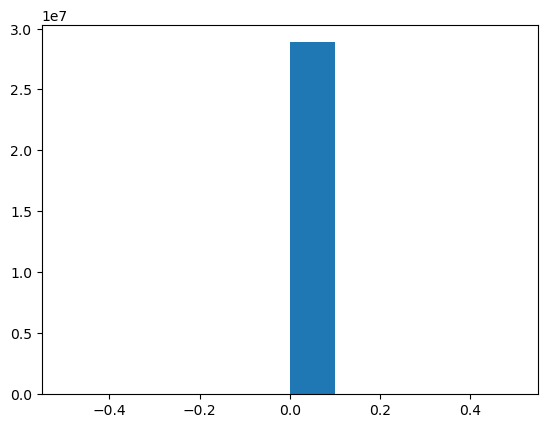

In [10]:
plt.hist(adata_ref.layers['counts'].data-np.round(adata_ref.layers['counts'].data))

In [11]:
adata_ref.layers['counts'].sum(0)

matrix([[  377., 11326.,  7276., ...,  2801.,  3400.,    84.]],
       dtype=float32)

In [12]:
adata_ref.obs_keys()

['original_annotation',
 'anno',
 'Dataset',
 'sample_name',
 'batch',
 'tech',
 'annot_harm',
 'mouseGut_predicted_labels',
 'mouseGut_over_clustering',
 'mouseGut_majority_voting',
 'mouseGut_conf_score',
 'res0.2',
 'res0.3',
 'res0.4',
 'lineage']

In [13]:
adata_ref.X.data

array([2.427236  , 0.90638644, 0.90638644, ..., 0.50416875, 0.50416875,
       0.8377744 ], dtype=float32)

In [13]:
adata_ref.X = adata_ref.layers['counts']

In [14]:
adata_ref

AnnData object with n_obs × n_vars = 16450 × 13607
    obs: 'original_annotation', 'anno', 'Dataset', 'sample_name', 'batch', 'tech', 'annot_harm', 'mouseGut_predicted_labels', 'mouseGut_over_clustering', 'mouseGut_majority_voting', 'mouseGut_conf_score', 'res0.2', 'res0.3', 'res0.4', 'lineage'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0'
    uns: 'Dataset_colors', 'anno_colors', 'annot_harm_colors', 'leiden', 'lineage_colors', 'log1p', 'mouseGut_majority_voting_colors', 'neighbors', 'neighbors_scvi', 'rank_genes_groups', 'res0.2_colors', 'res0.3_colors', 'res0.4_colors', 'umap'
    obsm: 'X_mde', 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'neighbors_scvi_connectivities', 'neighbors_scvi_distances'

In [16]:
adata_ref.var

,gene_ids-0,feature_types-0,genome-0,n_cells-0
Sox17,ENSMUSG00000025902,Gene Expression,mm10,221
Mrpl15,ENSMUSG00000033845,Gene Expression,mm10,3218
Lypla1,ENSMUSG00000025903,Gene Expression,mm10,2460
Tcea1,ENSMUSG00000033813,Gene Expression,mm10,6241
Rgs20,ENSMUSG00000002459,Gene Expression,mm10,3
...,...,...,...,...
Arhgap6,ENSMUSG00000031355,Gene Expression,mm10,742
Amelx,ENSMUSG00000031354,Gene Expression,mm10,13
Hccs,ENSMUSG00000031352,Gene Expression,mm10,1295
Mid1,ENSMUSG00000035299,Gene Expression,mm10,504


In [15]:
adata_ref

AnnData object with n_obs × n_vars = 16450 × 13607
    obs: 'original_annotation', 'anno', 'Dataset', 'sample_name', 'batch', 'tech', 'annot_harm', 'mouseGut_predicted_labels', 'mouseGut_over_clustering', 'mouseGut_majority_voting', 'mouseGut_conf_score', 'res0.2', 'res0.3', 'res0.4', 'lineage'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0'
    uns: 'Dataset_colors', 'anno_colors', 'annot_harm_colors', 'leiden', 'lineage_colors', 'log1p', 'mouseGut_majority_voting_colors', 'neighbors', 'neighbors_scvi', 'rank_genes_groups', 'res0.2_colors', 'res0.3_colors', 'res0.4_colors', 'umap'
    obsm: 'X_mde', 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'neighbors_scvi_connectivities', 'neighbors_scvi_distances'

<div class="alert alert-warning">
<b>Warning</b>
    
Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data.
</div>

In [17]:
#adata_ref.var['SYMBOL'] = adata_ref.var.index 
# rename 'GeneID-2' as necessary for your data
#adata_ref.var.set_index('gene_ids-0', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

In [18]:
adata_ref.var

,gene_ids-0,feature_types-0,genome-0,n_cells-0
Sox17,ENSMUSG00000025902,Gene Expression,mm10,221
Mrpl15,ENSMUSG00000033845,Gene Expression,mm10,3218
Lypla1,ENSMUSG00000025903,Gene Expression,mm10,2460
Tcea1,ENSMUSG00000033813,Gene Expression,mm10,6241
Rgs20,ENSMUSG00000002459,Gene Expression,mm10,3
...,...,...,...,...
Arhgap6,ENSMUSG00000031355,Gene Expression,mm10,742
Amelx,ENSMUSG00000031354,Gene Expression,mm10,13
Hccs,ENSMUSG00000031352,Gene Expression,mm10,1295
Mid1,ENSMUSG00000035299,Gene Expression,mm10,504


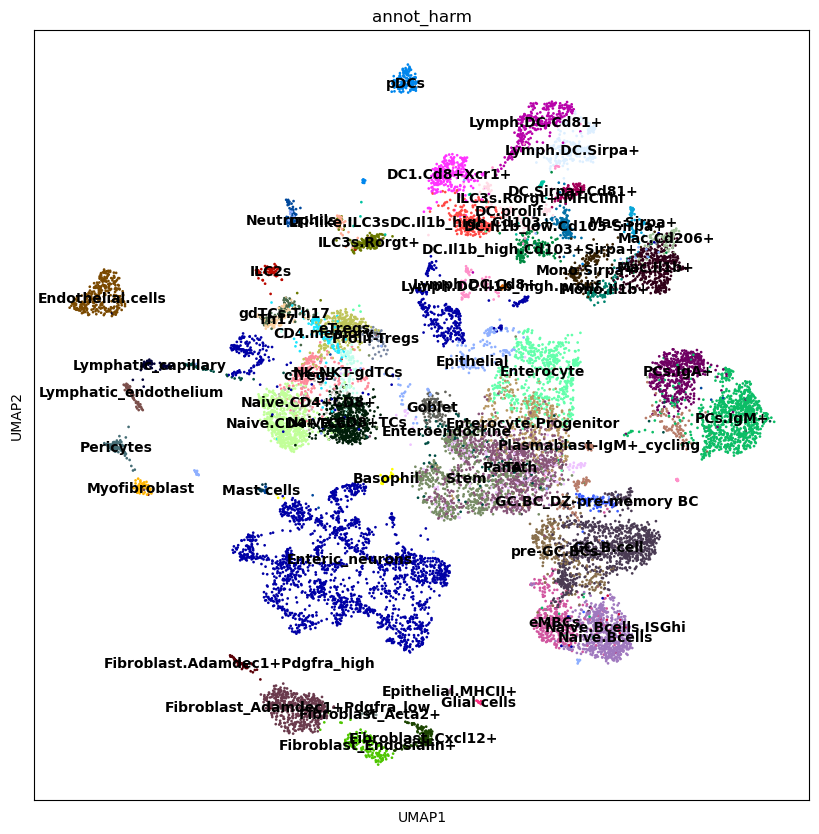

In [19]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_ref, color=['annot_harm'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

In [20]:
# Get count data
adata_ref.X=adata_ref.layers["counts"]

<div class="alert alert-info">
<b>Note!</b>
    
Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes. 
</div>

The default parameters `cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12` are a good starting point, however, you can increase the cut-off to exclude more genes. To preserve marker genes of rare cell types we recommend low `cell_count_cutoff=5`, however, `cell_percentage_cutoff2` and `nonz_mean_cutoff` can be increased to select between 8k-16k genes.

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

In this case, the downloaded dataset was already filtered using this method, hence no density under the orange rectangle (to be changed in the future version of the tutorial).

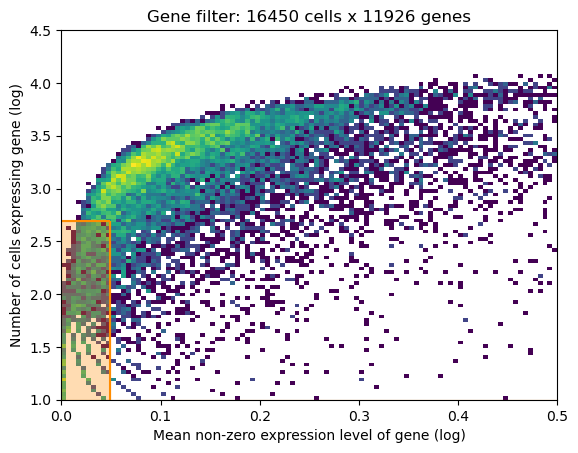

In [21]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

## Estimation of reference cell type signatures (NB regression) <a class="anchor" id="Estimation-of-reference-cell-type-signatures-(NB-regression)"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

<div class="alert alert-block alert-message">
<b>Preparing anndata.</b>
    
First, prepare anndata object for the regression model:
</div>

In [22]:
adata_ref

AnnData object with n_obs × n_vars = 16450 × 11926
    obs: 'original_annotation', 'anno', 'Dataset', 'sample_name', 'batch', 'tech', 'annot_harm', 'mouseGut_predicted_labels', 'mouseGut_over_clustering', 'mouseGut_majority_voting', 'mouseGut_conf_score', 'res0.2', 'res0.3', 'res0.4', 'lineage'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'n_cells', 'nonz_mean'
    uns: 'Dataset_colors', 'anno_colors', 'annot_harm_colors', 'leiden', 'lineage_colors', 'log1p', 'mouseGut_majority_voting_colors', 'neighbors', 'neighbors_scvi', 'rank_genes_groups', 'res0.2_colors', 'res0.3_colors', 'res0.4_colors', 'umap'
    obsm: 'X_mde', 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'neighbors_scvi_connectivities', 'neighbors_scvi_distances'

In [26]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref, 
                        # 10X reaction / sample / batch <-- Should be the SAMPLE_ID, 
                        batch_key='sample_name', 
                        # cell type, covariate used for constructing signatures
                        labels_key='annot_harm', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Dataset', 'tech']# <- Datasets or 5GEX,vs  3GEX.
                       )

/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/scvi/data/_utils.py:170: UserWarning: Category 3 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  category, alternate_column_key


In [27]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample_name',
│   'labels_key': 'annot_harm',
│   'categorical_covariate_keys': ['Dataset', 'tech'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  53   │
│         n_cells          │ 16450 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  63   │
│          n_vars          │ 11926 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                                       batch State Registry                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃                   Categories                   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_name'] │       07142017_PP_WT_Allergy_v2_Allergy        │          0          │
│                          │       07142017_PP_WT_Allergy_v2_Control        │          1          │
│                          │ 10172017_ctrl_allergy_nonPP_nonTB_v2_Allergy_1 │          2          │
│                          │   11292017_IgDnegSI_nonTBSI_v2_Allergy_nonTB   │          3          │
│                          │            CD45_MHCIIFlox_M1_HPDay4            │          4          │
│                          │         CD45_MHCIIFlox_M1_Homeostasis          │          5          │
│                          │            CD45_MHCIIFlox_M2_HPDay4            │          6          │
│                          │         CD45_MHCIIFlox_M2_Homeostasis          │          7          │
│                          │            CD45_MHCIIFlox_M3_HPDay4            │          8          │
│                          │         CD45_MHCIIFlox_M3_Homeostasis          │          9          │
│                          │           CD45_MHCIIGut--_M1_HPDay4            │         10          │
│                          │         CD45_MHCIIGut--_M1_Homeostasis         │         11          │
│                          │           CD45_MHCIIGut--_M2_HPDay4            │         12          │
│                          │         CD45_MHCIIGut--_M2_Homeostasis         │         13          │
│                          │           CD45_MHCIIGut--_M3_HPDay4            │         14          │
│                          │         CD45_MHCIIGut--_M3_Homeostasis         │         15          │
│                          │               CII_Flox_Control_1               │         16          │
│                          │               CII_Flox_Control_2               │         17          │
│                          │                   CII_dGut_1                   │         18          │
│                          │                   CII_dGut_2                   │         19          │
│                          │                       CP                       │         20          │
│                          │                       LA                       │         21          │
│                          │                       LP                       │         22          │
│                          │                     M1_S1                      │         23          │
│                          │                     M1_S2                      │         24          │
│                          │                     M1_S3                      │         25          │
│                          │                     M1_S4                      │         26          │
│                          │                     M4_S15                     │         27          │
│                          │                     M4_S16                     │         28          │
│                          │                     M5_S17                     │         29          │
│                          │                     M5_S20                     │         30          │
│                          │                     M5_S22                     │         31          │
│                          │                     M5_S25                     │         32          │
│                          │                     M5_S29                     │         33          │
│                          │                     M5_S30                     │         34          │
│                          │                     M6_S18                     │         35          │


                               labels State Registry                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['annot_harm'] │            Basophil             │          0          │
│                         │           CD4.memory            │          1          │
│                         │          DC1.Cd8+Xcr1+          │          2          │
│                         │       DC.Il1b_high.Cd103+       │          3          │
│                         │    DC.Il1b_high.Cd103+Sirpa+    │          4          │
│                         │    DC.Il1b_low.Cd103-Sirpa+     │          5          │
│                         │         DC.Sirpa+Cd81+          │          6          │
│                         │           DC.prolif.            │          7          │
│                         │        Endothelial.cells        │          8          │
│                         │         Enteric_neurons         │          9          │
│                         │           Enterocyte            │         10          │
│                         │      Enterocyte.Progenitor      │         11          │
│                         │         Enteroendocrine         │         12          │
│                         │           Epithelial            │         13          │
│                         │        Epithelial.MHCII+        │         14          │
│                         │ Fibroblast.Adamdec1+Pdgfra_high │         15          │
│                         │        Fibroblast_Acta2+        │         16          │
│                         │ Fibroblast_Adamdec1+Pdgfra_low  │         17          │
│                         │       Fibroblast_Cxcl12+        │         18          │
│                         │     Fibroblast_Endosialin+      │         19          │
│                         │     GC.BC_DZ-pre-memory BC      │         20          │
│                         │            GC_B.cell            │         21          │
│                         │           Glial cells           │         22          │
│                         │             Goblet              │         23          │
│                         │              ILC2s              │         24          │
│                         │          ILC3s.Rorgt+           │         25          │
│                         │      ILC3s.Rorgt+.MHCIIhi       │         26          │
│                         │         LTi-like.ILC3s          │         27          │
│                         │          Lymph.DC.Cd8+          │         28          │
│                         │         Lymph.DC.Cd81+          │         29          │
│                         │   Lymph.DC.Il1b_high.prolif.    │         30          │
│                         │         Lymph.DC.Sirpa+         │         31          │
│                         │       Lymphatic_capillary       │         32          │
│                         │      Lymphatic_endothelium      │         33          │
│                         │           Mac.Cd206+            │         34          │
│                         │            Mac.Il1b+            │         35          │
│                         │           Mac.Sirpa+            │         36          │
│                         │           Mast cells            │         37          │
│                         │           Mono.Il1b+            │         38          │
│                         │           Mono.Sirpa+           │         39          │
│                         │          Myofibroblast          │         40          │
│                         │          NK-NKT-gdTCs           │         41          │
│                         │          Naive.Bcells           │         42          │
│                         │       Naive.Bcells.ISGhi

              extra_categorical_covs State Registry              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Dataset'] │    Biton2018     │          0          │
│                      │ Drokhlyansky2020 │          1          │
│                      │     NicheSeq     │          2          │
│                      │      Xu2019      │          3          │
│                      │                  │                     │
│  adata.obs['tech']   │       3GEX       │          0          │
│                      │       5GEX       │          1          │
│                      │                  │                     │
└──────────────────────┴──────────────────┴─────────────────────┘

<div class="alert alert-block alert-message">
<b>Training model.</b>
    
Now we train the model to estimate the reference cell type signatures. 
    
Note that to achieve convergence on your data (=to get stabilization of the loss) you may need to increase `max_epochs=250` (See below).
    
Also note that here we are using `batch_size=2500` which is much larger than scvi-tools default and perform training on all cells in the data (`train_size=1`) - both parameters are defaults.
</div>

In [28]:
mod.train(max_epochs=250, use_gpu=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 250/250: 100%|███████████████████████████████| 250/250 [06:54<00:00,  1.67s/it, v_num=1, elbo_train=9.1e+7]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|███████████████████████████████| 250/250 [06:54<00:00,  1.66s/it, v_num=1, elbo_train=9.1e+7]


<div class="alert alert-block alert-message">
<b>Determine if the model needs more training.</b>
</div>

Here, we plot ELBO loss history during training, removing first 20 epochs from the plot.
This plot should have a decreasing trend and level off by the end of training. If it is still decreasing, increase `max_epochs`.

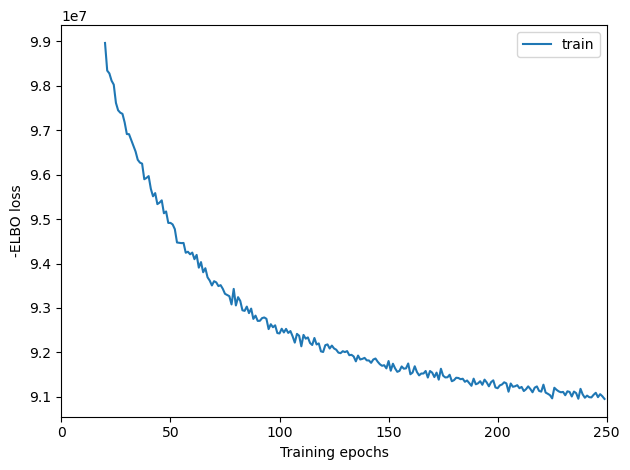

In [29]:
mod.plot_history(20)

In [30]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc_tissueDetQCed.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|███████████████████████████████████████| 999/999 [00:17<00:00, 58.67it/s]


'/lustre/scratch126/cellgen/team205/rb29/mice-gut.TCRtg/mouseST_C2L/models//reference_signatures/sc_tissueDetQCed.h5ad'

You can compute the 5%, 50% and 95% quantiles of the posterior distribution directly rather than using 1000 samples from the distribution (or any other quantiles). This speeds up application on large datasets and requires less memory - however, posterior mean and standard deviation cannot be computed this way.

```python
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=True,
    # choose quantiles
    add_to_obsm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': True}
)
```

<div class="alert alert-block alert-message">
<b>Examine QC plots.</b>
</div>

1. Reconstruction accuracy to assess if there are any issues with inference. This 2D histogram plot should have most observations along a noisy diagonal. 

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

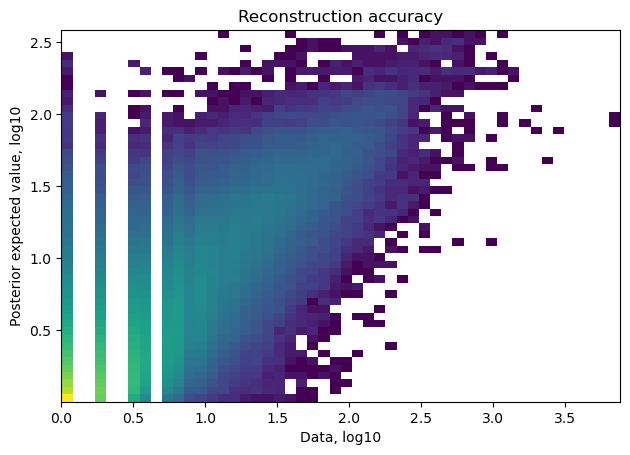

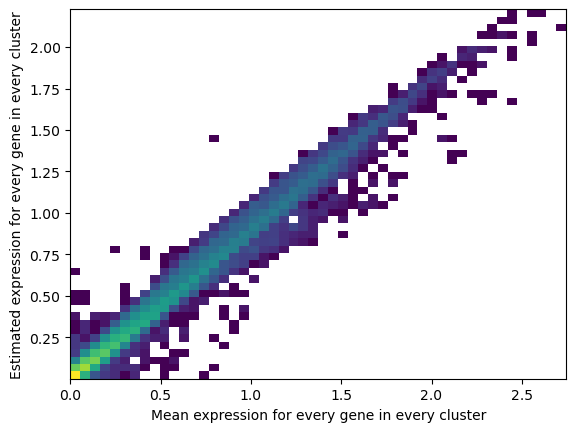

In [31]:
mod.plot_QC()

The model and output h5ad can be loaded later like this:
```python
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)
```

In [36]:
#load model:
adata_file = f"{ref_run_name}/sc_tissueDetQCed.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File                                                                                                      
         /lustre/scratch126/cellgen/team205/rb29/mice-gut.TCRtg/mouseST_C2L/models//reference_signatures/model.pt  
         already downloaded                                                                                        


/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/scvi/data/_utils.py:170: UserWarning: Category 3 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  category, alternate_column_key
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you

Epoch 1/1000:   0%|                                | 1/1000 [00:00<02:45,  6.05it/s, v_num=1, elbo_train=1.15e+8]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/1000:   0%|                                | 1/1000 [00:00<02:57,  5.64it/s, v_num=1, elbo_train=1.15e+8]


<div class="alert alert-block alert-message">
<b>Extracting reference cell types signatures as a pd.DataFrame.</b>
    
All parameters of the a Negative Binomial regression model are exported into reference anndata object, however for spatial mapping we just need the estimated expression of every gene in every cell type. Here we extract that from standard output:
</div>

In [32]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Basophil,CD4.memory,DC1.Cd8+Xcr1+,DC.Il1b_high.Cd103+,DC.Il1b_high.Cd103+Sirpa+
Sox17,0.005989,0.004270,0.002498,0.003316,0.004155
Mrpl15,0.190983,0.099195,0.476085,0.489929,0.292576
Lypla1,0.095418,0.062984,0.344234,0.222035,0.188981
Tcea1,0.005718,0.356084,1.180993,0.794589,0.691686
Rgs20,0.006096,0.004515,0.002238,0.003026,0.004229


In [33]:
### SAVE THIS AS CSV
inf_aver.to_csv("/lustre/scratch126/cellgen/team205/rb29/mice-gut.TCRtg/mouseST_C2L/20230516_info_aver.csv")

### Modules and their versions used for this analysis


Useful for debugging and reporting issues.

In [34]:
cell2location.utils.list_imported_modules()

sys 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
re 2.2.1
ipykernel 6.16.2
ipykernel._version 6.16.2
json 2.0.9
jupyter_client 7.4.8
jupyter_client._version 7.4.8
traitlets 5.6.0
traitlets._version 5.6.0
logging 0.5.1.2
zmq 24.0.1
platform 1.0.8
ctypes 1.1.0
_ctypes 1.1.0
zmq.sugar 24.0.1
zmq.sugar.version 24.0.1
socketserver 0.4
argparse 1.1
tornado 6.2
zlib 1.0
colorama 0.4.6
_curses b'2.2'
dateutil 2.8.2
dateutil._version 2.8.2
six 1.16.0
decimal 1.70
_decimal 1.70
jupyter_core 4.11.1
jupyter_core.version 4.11.1
entrypoints 0.4
IPython 7.33.0
IPython.core.release 7.33.0
IPython.core.crashhandler 7.33.0
pygments 2.13.0
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.1.1
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.33
wcwidth 0.2.5
jedi 0.18.2
parso 0.8.3
IPython.core.magics.code 7.33.0
urllib.request 3.7
psutil 5.9.3
debugpy 1.6.3
debugpy.public_api 1.6.3
xmlrpc.client 3.7
http.server 0.6
pkg_reso